In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import evaluate_effectiveness
from scripts.generate_blurred import generate_blurred
from scripts.utils import io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'

configCAMResOG = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOG = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMResOGAdam = '../CAMModels/resnet/compCars_Original/adamw/resnet50_b128x2_compcars-original-split_adamw.py'
checkpointCAMResOGAdam = '../CAMModels/resnet/compCars_Original/adamw/latest.pth'
configCAMResCol = '../CAMModels/resnet/compCars_Color/resnet50_b128x2_compcars-color-split.py'
checkpointCAMResCol = '../CAMModels/resnet/compCars_Color/latest.pth'
configCAMResWeb = '../CAMModels/resnet/compCars_Web/resnet50_b128x2_compcars-web-original-split.py'
checkpointCAMResWeb = '../CAMModels/resnet/compCars_Web/latest.pth'
configCAMResWebAdam = '../CAMModels/resnet/compCars_Web/adamw/resnet50_b128x2_compcars-web-original-split_adamw.py'
checkpointCAMResWebAdam = '../CAMModels/resnet/compCars_Web/adamw/latest.pth'
configCAMResStanford = '../CAMModels/resnet/stanfordCars_Original/resnet50_b128x2_stanford.py'
checkpointCAMResStanford = '../CAMModels/resnet/stanfordCars_Original/latest.pth'

configCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/latest.pth'
configCAMSwinSmallCol = '../CAMModels/swinSmall/compCars_Color/swin-small_b128x2_compcars-color-split.py'
checkpointCAMSwinSmallCol = '../CAMModels/swinSmall/compCars_Color/latest.pth'
configCAMSwinSmallWeb = '../CAMModels/swinSmall/compCars_Web/swin-small_b128x2_compcars-web-original-split.py'
checkpointCAMSwinSmallWeb = '../CAMModels/swinSmall/compCars_Web/latest.pth'
configCAMSwinSmallStanford = '../CAMModels/swinSmall/stanfordCars_Original/swin-small_b128x2_stanford.py'
checkpointCAMSwinSmallStanford = '../CAMModels/swinSmall/stanfordCars_Original/latest.pth'

configCAMSwinBaseOG = '../CAMModels/swinBase/compCars_Original/swin-base_b128x2_compcars-original-split.py'
checkpointCAMSwinBaseOG = '../CAMModels/swinBase/compCars_Original/latest.pth'
configCAMSwinBaseCol = '../CAMModels/swinBase/compCars_Color/swin-base_b128x2_compcars-color-split.py'
checkpointCAMSwinBaseCol = '../CAMModels/swinBase/compCars_Color/latest.pth'
configCAMSwinBaseWeb = '../CAMModels/swinBase/compCars_Web/swin-base_b128x2_compcars-web-original-split.py'
checkpointCAMSwinBaseWeb = '../CAMModels/swinBase/compCars_Web/latest.pth'
configCAMSwinBaseStanford = '../CAMModels/swinBase/stanfordCars_Original/swin-base_b128x2_stanford.py'
checkpointCAMSwinBaseStanford = '../CAMModels/swinBase/stanfordCars_Original/latest.pth'

"""Retrained Models"""
configCAMResOGblurFBumper_FLLight_Hood='../CAMModels/resnet/compCars_Original_blurFBumper_Background_Hood/resnet50_b128x2_compcars-original-split_fbumper_background_hood.py'
checkpointCAMResOGblurFBumper_FLLight_Hood='../CAMModels/resnet/compCars_Original_blurFBumper_Background_Hood/latest.pth'
configCAMResOGblurFBumper_Background_Hood='../CAMModels/resnet/compCars_Original_blurFBumper_FLLight_Hood/resnet50_b128x2_compcars-original-split_fbumper_fllight_hood.py'
checkpointCAMResOGblurFBumper_Background_Hood='../CAMModels/resnet/compCars_Original_blurFBumper_FLLight_Hood/latest.pth'
configCAMResColblurFBumper_FLLight_Hood='../CAMModels/resnet/compCars_Colors_blurFBumper_FLLight_Hood/resnet50_b128x2_compcars-color-split_fbumper_fllight_hood.py'
checkpointCAMResColblurFBumper_FLLight_Hood='../CAMModels/resnet/compCars_Colors_blurFBumper_FLLight_Hood/latest.pth'
configCAMResColblurFBumper_Background_Hood='../CAMModels/resnet/compCars_Colors_blurFBumper_Background_Hood/resnet50_b128x2_compcars-color-split_fbumper_background_hood.py'
checkpointCAMResColblurFBumper_Background_Hood='../CAMModels/resnet/compCars_Colors_blurFBumper_Background_Hood/latest.pth'
configCAMResWebblurBackground_BBumper_FBumper='../CAMModels/resnet/compCars_Web_blurBackground_BBumper_FBumper/resnet50_b128x2_compcars-web-original-split_background_bbumper_fbumper.py'
checkpointCAMResWebblurBackground_BBumper_FBumper='../CAMModels/resnet/compCars_Web_blurBackground_BBumper_FBumper/latest.pth'

configCAMSwinSmallOGblurFBumper_Background_Hood='../CAMModels/swinSmall/compcars_Original_blurFBumper_Background_Hood/swin-small_b128x2_compcars-original-split_fbumper_background_hood.py'
checkpointCAMSwinSmallOGblurFBumper_Background_Hood='../CAMModels/swinSmall/compcars_Original_blurFBumper_Background_Hood/latest.pth'
configCAMSwinSmallColblurFBumper_Background_Hood='../CAMModels/swinSmall/compcars_Color_blurFBumper_Background_Hood/swin-small_b128x2_compcars-color-split_fbumper_background_hood.py'
checkpointCAMSwinSmallColblurFBumper_Background_Hood='../CAMModels/swinSmall/compcars_Color_blurFBumper_Background_Hood/latest.pth'
configCAMSwinSmallWebblurBackground_BBumper_FBumper='../CAMModels/swinSmall/compcars_WebOriginal_blurBackground_BBumper_FBumper/swin-small_b128x2_compcars-web-original-split_background_bbumper_fbumper.py'
checkpointCAMSwinSmallWebblurBackground_BBumper_FBumper='../CAMModels/swinSmall/compcars_WebOriginal_blurBackground_BBumper_FBumper/latest.pth'

configCAMSwinBaseOGblurFBumper_FGlass_Hood='../CAMModels/swinBase/compcars_Original_blurFBumper_FGlass_Hood/swin-base_b128x2_compcars-original-split_fbumper_fglass_hood.py'
checkpointCAMSwinBaseOGblurFBumper_FGlass_Hood='../CAMModels/swinBase/compcars_Original_blurFBumper_FGlass_Hood/latest.pth'
configCAMSwinBaseOGblurFBumper_FLLight_Hood='../CAMModels/swinBase/compcars_Original_blurFBumper_FLLight_Hood/swin-base_b128x2_compcars-original-split_fbumper_fllight_hood.py'
checkpointCAMSwinBaseOGblurFBumper_FLLight_Hood='../CAMModels/swinBase/compcars_Original_blurFBumper_FLLight_Hood/latest.pth'
configCAMSwinBaseColblurFBumper_FGlass_Hood='../CAMModels/swinBase/compcars_Color_blurFBumper_FGlass_Hood/swin-base_b128x2_compcars-color-split_fbumper_fglass_hood.py'
checkpointCAMSwinBaseColblurFBumper_FGlass_Hood='../CAMModels/swinBase/compcars_Color_blurFBumper_FGlass_Hood/latest.pth'
configCAMSwinBaseColblurFBumper_FLLight_Hood='../CAMModels/swinBase/compcars_Color_blurFBumper_FLLight_Hood/swin-base_b128x2_compcars-color-split_fbumper_fllight_hood.py'
checkpointCAMSwinBaseColblurFBumper_FLLight_Hood='../CAMModels/swinBase/compcars_Color_blurFBumper_FLLight_Hood/latest.pth'
configCAMSwinBaseWebblurFBumper_Background_Hood='../CAMModels/swinBase/compcars_Web_blurFBumper_Background_Hood/swin-base_b128x2_compcars-web-original-split_fbumper_background_hood.py'
checkpointCAMSwinBaseWebblurFBumper_Background_Hood='../CAMModels/swinBase/compcars_Web_blurFBumper_Background_Hood/latest.pth'



annfileValOriginal = '../data/CompCars_sv_original_split/meta/val.txt'
annfileValColor = '../data/CompCars_sv_color_split/meta/val.txt'
annfileValWeb = '../data/CompCars_web_original_split/meta/val.txt'
annfileValStanford = '../data/StanfordCars_original_split/meta/val.txt'

annfileValWebShareOriginal = '../data/CompCars_web_original_split/meta/annfile_shared_original.txt'

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPathNoScaleOG = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScale.npz'
segDataPathNoScaleColor = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Color/valAllSegsNoScale.npz'
segDataPathNoScaleWeb = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web/valAllSegsNoScale.npz'
segDataPathNoScaleStanfordOG = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/StanfordCars_Original/valAllSegsNoScale.npz'

imgRootValOriginal = '../data/CompCars_sv_original_split/val'
imgRootValColor = '../data/CompCars_sv_color_split/val'
imgRootValWeb = '../data/CompCars_web_original_split/val'
imgRootValStandford = '../data/StanfordCars_original_split/val'

imgRootOGBlurBackground = '../data/CompCars_sv_original_split/blurred/blurredBackground'
imgRootOGBlurFLLight_Hood_FBumper = '../data/CompCars_sv_original_split/blurred/blurredFrontLeftLight_Hood_FrontBumper'
imgRootOGBlurBackground_Hood_FBumper = '../data/CompCars_sv_original_split/blurred/blurredBackground_Hood_FrontBumper'
imgRootOGBlurFrontGlass_Hood_FBumper = '../data/CompCars_sv_original_split/blurred/blurredFrontGlass_Hood_FrontBumper'

imgRootColorBlurBackground = '../data/CompCars_sv_color_split/blurred/blurredBackground'
imgRootColorBlurFLLight_Hood_FBumper = '../data/CompCars_sv_color_split/blurred/blurredFrontLeftLight_Hood_FrontBumper'
imgRootColorBlurBackground_Hood_FBumper = '../data/CompCars_sv_color_split/blurred/blurredBackground_Hood_FrontBumper'
imgRootColorBlurFrontGlass_Hood_FBumper = '../data/CompCars_sv_color_split/blurred/blurredFrontGlass_Hood_FrontBumper'

imgRootWebBlurBackground = '../data/CompCars_web_original_split/blurred/blurredBackground'
imgRootWebBlurBBumper_Background_FBumper = '../data/CompCars_web_original_split/blurred/blurredBackBumper_Background_FrontBumper'
imgRootWebBlurBackground_Hood_FBumper = '../data/CompCars_web_original_split/blurred/blurredBackground_Hood_FrontBumper'

In [6]:
igR = imgRootValOriginal
cfgC = configCAMSwinBaseOG
ckpC = checkpointCAMSwinBaseOG
svPre = '../preGenData/CompCars_Original/SwinBase/GPU/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++GPU', '--method', 'gradcam++', '--vit-like', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsXGradGPU', '--method', 'xgradcam', '--vit-like', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigenGPU', '--method', 'eigencam', '--vit-like', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigenGradGPU', '--method', 'eigengradcam', '--vit-like', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsLayerGPU', '--method', 'layercam', '--vit-like', '--device', 'cuda'])

Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:True
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 12.7 task/s, elapsed: 1047s, ETA:     0sSave Split file for Cams
Save generated CAMs to ../preGenData/CompCars_Original/SwinBase/GPU\valAllCAMsGrad++GPU.npz
Method for CAM generation: xgradcam, eigen-smooth:False, aug-smooth:False, vit-like:True
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 12.6 task/s, elapsed: 1057s, ETA:     0sSave Split file for Cams
Save generated CAMs to ../preGenData/CompCars_Original/SwinBase/GPU\valAllCAMsXGradGPU.npz
Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:True
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 8.5 task/s, elap

In [3]:
igR = imgRootValOriginal
cfgC = configCAMResOGAdam
ckpC = checkpointCAMResOGAdam
svPre = '../preGenData/CompCars_Original/ResNet/Adamw/'
#generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])

Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 2.4 task/s, elapsed: 5613s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/CompCars_Original/ResNet/Adamw\valAllCAMsEigen.txt
Save generated CAMs to ../preGenData/CompCars_Original/ResNet/Adamw\valAllCAMsEigen.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\io.py:108: UserWarning: Using generate_split_files will redirect the call to generate_ann_file. Consider directly calling that function
  warnings.warn("Using generate_split_files will redirect the call to generate_ann_file. Consider directly calling that function")


In [3]:
generate_segs.main(['../data/CompCars_sv_original_split/train', configSeg, checkpointSeg,
                    '-s', 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScaleTrain'])
generate_segs.main(['../data/CompCars_sv_color_split/train', configSeg, checkpointSeg,
                    '-s', 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Color/valAllSegsNoScaleTrain'])
generate_segs.main(['../data/CompCars_web_original_split/train', configSeg, checkpointSeg,
                    '-s', 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web/valAllSegsNoScaleTrain'])

Saving resulting segmentation masks in G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\io.py:108: UserWarning: Using generate_split_files will redirect the call to generate_ann_file. Consider directly calling that function
  warnings.warn("Using generate_split_files will redirect the call to generate_ann_file. Consider directly calling that function")


Creating annotation file at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original\valAllSegsNoScaleTrain.txt
Calculating segmentation results.
[>>>>>>>>>>>>>>>>>>>>>>>] 31148/31148, 10.1 task/s, elapsed: 3080s, ETA:     0s
Saving results at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original\valAllSegsNoScaleTrain.npz
Saving resulting segmentation masks in G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Color
Creating annotation file at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Color\valAllSegsNoScaleTrain.txt
Calculating segmentation results.
[>>>>>>>>>>>>>>>>>>>>>>>>] 31062/31062, 9.2 task/s, elapsed: 3393s, ETA:     0s
Saving results at G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Color\valAllSegsNoScaleTrain.npz
Saving resulting segmentation masks in G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web
Creating annotation file at G:/XAI-Vehicle-Classification/preGenData/S

In [4]:
segDataPathNoScaleOGTrain = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScaleTrain.npz'
generate_blurred(configCAMResOG, checkpointCAMResOG, 'background', segDataPathNoScaleOGTrain,
                 '../data/CompCars_sv_original_split/train',
                 '../data/CompCars_sv_original_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Original/blurredBackground')
generate_blurred(configCAMResOG, checkpointCAMResOG, ['front_left_light','hood','front_bumper'], segDataPathNoScaleOGTrain, 
                 '../data/CompCars_sv_original_split/train',
                 '../data/CompCars_sv_original_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Original/blurredFrontLeftLight_Hood_FrontBumper')
generate_blurred(configCAMResOG, checkpointCAMResOG, ['background','hood','front_bumper'], segDataPathNoScaleOGTrain, 
                 '../data/CompCars_sv_original_split/train',
                 '../data/CompCars_sv_original_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Original/blurredBackground_Hood_FrontBumper')
generate_blurred(configCAMResOG, checkpointCAMResOG, ['front_glass','hood','front_bumper'], segDataPathNoScaleOGTrain, 
                 '../data/CompCars_sv_original_split/train',
                 '../data/CompCars_sv_original_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Original/blurredFrontGlass_Hood_FrontBumper')

Creating blurred Images in Original/blurredBackground
Blurring segments into single color
Blurred Images will be saved to Original/blurredBackground
[>>>>>>>>>>>>>>>>>>>>>>>] 31148/31148, 20.8 task/s, elapsed: 1494s, ETA:     0sCreating blurred Images in Original/blurredFrontLeftLight_Hood_FrontBumper
Blurring segments into single color
Blurred Images will be saved to Original/blurredFrontLeftLight_Hood_FrontBumper
[>>>>>>>>>>>>>>>>>>>>>>>] 31148/31148, 20.4 task/s, elapsed: 1524s, ETA:     0sCreating blurred Images in Original/blurredBackground_Hood_FrontBumper
Blurring segments into single color
Blurred Images will be saved to Original/blurredBackground_Hood_FrontBumper
[>>>>>>>>>>>>>>>>>>>>>>>] 31148/31148, 21.5 task/s, elapsed: 1449s, ETA:     0sCreating blurred Images in Original/blurredFrontGlass_Hood_FrontBumper
Blurring segments into single color
Blurred Images will be saved to Original/blurredFrontGlass_Hood_FrontBumper
[>>>>>>>>>>>>>>>>>>>>>>>] 31148/31148, 20.1 task/s, elaps

In [3]:
segDataPathNoScaleColorTrain = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Color/valAllSegsNoScaleTrain.npz'

generate_blurred(configCAMResCol, checkpointCAMResCol, 'background', segDataPathNoScaleColorTrain, 
                 '../data/CompCars_sv_color_split/train', 
                 '../data/CompCars_sv_color_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Color/blurredBackground')
generate_blurred(configCAMResCol, checkpointCAMResCol, ['front_left_light','hood','front_bumper'], segDataPathNoScaleColorTrain,
                 '../data/CompCars_sv_color_split/train', 
                 '../data/CompCars_sv_color_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Color/blurredFrontLeftLight_Hood_FrontBumper')
generate_blurred(configCAMResCol, checkpointCAMResCol, ['background','hood','front_bumper'], segDataPathNoScaleColorTrain, 
                 '../data/CompCars_sv_color_split/train', 
                 '../data/CompCars_sv_color_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Color/blurredBackground_Hood_FrontBumper')
generate_blurred(configCAMResCol, checkpointCAMResCol, ['front_glass','hood','front_bumper'], segDataPathNoScaleColorTrain, 
                 '../data/CompCars_sv_color_split/train', 
                 '../data/CompCars_sv_color_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Color/blurredFrontGlass_Hood_FrontBumper')

Creating blurred Images in Color/blurredBackground
Blurring segments into single color
Blurred Images will be saved to Color/blurredBackground
[>>>>>>>>>>>>>>>>>>>>>>>] 31062/31062, 20.2 task/s, elapsed: 1536s, ETA:     0sCreating blurred Images in Color/blurredFrontLeftLight_Hood_FrontBumper
Blurring segments into single color
Blurred Images will be saved to Color/blurredFrontLeftLight_Hood_FrontBumper
[>>>>>>>>>>>>>>>>>>>>>>>] 31062/31062, 22.2 task/s, elapsed: 1399s, ETA:     0sCreating blurred Images in Color/blurredBackground_Hood_FrontBumper
Blurring segments into single color
Blurred Images will be saved to Color/blurredBackground_Hood_FrontBumper
[>>>>>>>>>>>>>>>>>>>>>>>] 31062/31062, 20.3 task/s, elapsed: 1531s, ETA:     0sCreating blurred Images in Color/blurredFrontGlass_Hood_FrontBumper
Blurring segments into single color
Blurred Images will be saved to Color/blurredFrontGlass_Hood_FrontBumper
[>>>>>>>>>>>>>>>>>>>>>>>] 31062/31062, 20.4 task/s, elapsed: 1522s, ETA:     0s

In [4]:
segDataPathNoScaleWebTrain = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Web/valAllSegsNoScaleTrain.npz'
generate_blurred(configCAMResWeb, checkpointCAMResWeb, 'background', segDataPathNoScaleWebTrain, 
                 '../data/CompCars_web_original_split/train', 
                 '../data/CompCars_web_original_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Web/blurredBackground')
generate_blurred(configCAMResWeb, checkpointCAMResWeb, ['back_bumper','background','front_bumper'], segDataPathNoScaleWebTrain, 
                 '../data/CompCars_web_original_split/train', 
                 '../data/CompCars_web_original_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Web/blurredBackBumper_Background_FrontBumper')
generate_blurred(configCAMResWeb, checkpointCAMResWeb, ['background','hood','front_bumper'], segDataPathNoScaleWebTrain,
                 '../data/CompCars_web_original_split/train', 
                 '../data/CompCars_web_original_split/meta/train.txt',
                configSeg, checkpointSeg, singleColor=True,
                saveDir='Web/blurredBackground_Hood_FrontBumper')

Creating blurred Images in Web/blurredBackground
Blurring segments into single color
Blurred Images will be saved to Web/blurredBackground
[>>>>>>>>>>>>>>>>>>>>>>>] 36456/36456, 18.4 task/s, elapsed: 1985s, ETA:     0sCreating blurred Images in Web/blurredBackBumper_Background_FrontBumper
Blurring segments into single color
Blurred Images will be saved to Web/blurredBackBumper_Background_FrontBumper
[>>>>>>>>>>>>>>>>>>>>>>>] 36456/36456, 18.6 task/s, elapsed: 1958s, ETA:     0sCreating blurred Images in Web/blurredBackground_Hood_FrontBumper
Blurring segments into single color
Blurred Images will be saved to Web/blurredBackground_Hood_FrontBumper
[>>>>>>>>>>>>>>>>>>>>>>>] 36456/36456, 18.7 task/s, elapsed: 1954s, ETA:     0s

In [6]:
"""CompCars Original"""
igR = imgRootValOriginal
"""Retrain"""
"""Blur Front Bumper, Front Left Light, Hood """
#ResNet
cfgC = configCAMResOGblurFBumper_FLLight_Hood
ckpC = checkpointCAMResOGblurFBumper_FLLight_Hood
svPre = '../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Original/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
#SwinBase
cfgC = configCAMSwinBaseOGblurFBumper_FLLight_Hood
ckpC = checkpointCAMSwinBaseOGblurFBumper_FLLight_Hood
svPre = '../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Original/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Background, Hood"""
#ResNet
cfgC = configCAMResOGblurFBumper_Background_Hood
ckpC = checkpointCAMResOGblurFBumper_Background_Hood
svPre = '../preGenData/retrained/blurredBackground_Hood_FBumper_OGImages/CompCars_Original/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
#SwinSmall
cfgC = configCAMSwinSmallOGblurFBumper_Background_Hood
ckpC = checkpointCAMSwinSmallOGblurFBumper_Background_Hood
svPre = '../preGenData/retrained/blurredBackground_Hood_FBumper_OGImages/CompCars_Original/SwinSmall/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Front Glass, Hood"""
#SwinBase
cfgC = configCAMSwinBaseOGblurFBumper_FGlass_Hood
ckpC = checkpointCAMSwinBaseOGblurFBumper_FGlass_Hood
svPre = '../preGenData/retrained/blurredFGlass_Hood_FBumper_OGImages/CompCars_Original/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 28.6 task/s, elapsed: 466s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Original/ResNet\valAllCAMsGrad++.txt
Save generated CAMs to ../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Original/ResNet\valAllCAMsGrad++.npz
Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 3.7 task/s, elapsed: 3578s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Original/ResNet\valAllCAMsEigen.txt
Save generated CAMs 

In [7]:
"""CompCars Color"""
igR = imgRootValColor
"""Retrain"""
"""Blur Front Bumper, Front Left Light, Hood """
#ResNet
cfgC = configCAMResColblurFBumper_FLLight_Hood
ckpC = checkpointCAMResColblurFBumper_FLLight_Hood  
svPre = '../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Color/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
#SwinBase
cfgC = configCAMSwinBaseColblurFBumper_FLLight_Hood
ckpC = checkpointCAMSwinBaseColblurFBumper_FLLight_Hood
svPre = '../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Color/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Background, Hood"""
#ResNet
cfgC = configCAMResColblurFBumper_Background_Hood
ckpC = checkpointCAMResColblurFBumper_Background_Hood
svPre = '../preGenData/retrained/blurredBackground_Hood_FBumper_OGImages/CompCars_Color/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
#SwinSmall
cfgC = configCAMSwinSmallColblurFBumper_Background_Hood
ckpC = checkpointCAMSwinSmallColblurFBumper_Background_Hood
svPre = '../preGenData/retrained/blurredBackground_Hood_FBumper_OGImages/CompCars_Color/SwinSmall/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Front Glass, Hood"""
#SwinBase
cfgC = configCAMSwinBaseColblurFBumper_FGlass_Hood
ckpC = checkpointCAMSwinBaseColblurFBumper_FGlass_Hood
svPre = '../preGenData/retrained/blurredFGlass_Hood_FBumper_OGImages/CompCars_Color/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13379/13379, 25.0 task/s, elapsed: 534s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Color/ResNet\valAllCAMsGrad++.txt
Save generated CAMs to ../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Color/ResNet\valAllCAMsGrad++.npz
Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13379/13379, 3.6 task/s, elapsed: 3731s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrained/blurredFLLight_Hood_FBumper_OGImages/CompCars_Color/ResNet\valAllCAMsEigen.txt
Save generated CAMs to ../pre

In [6]:
"""CompCars Web"""
igR = imgRootValWeb
"""Retrain"""
"""Blur Background, Back Bumper, Front Bumper """
#ResNet
cfgC = configCAMResWebblurBackground_BBumper_FBumper
ckpC = checkpointCAMResWebblurBackground_BBumper_FBumper
svPre = '../preGenData/retrained/blurredBackground_BBumper_FBumper_OGImages/CompCars_Web/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
#SwinSmall
cfgC = configCAMSwinSmallWebblurBackground_BBumper_FBumper
ckpC = checkpointCAMSwinSmallWebblurBackground_BBumper_FBumper
svPre = '../preGenData/retrained/blurredBackground_BBumper_FBumper_OGImages/CompCars_Web/SwinSmall/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Background, Hood"""
# SwinBase
cfgC = configCAMSwinBaseWebblurFBumper_Background_Hood  
ckpC = checkpointCAMSwinBaseWebblurFBumper_Background_Hood
svPre = '../preGenData/retrained/blurredBackground_Hood_FBumper_OGImages/CompCars_Web/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])

Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 15627/15627, 3.4 task/s, elapsed: 4550s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrained/blurredBackground_BBumper_FBumper/CompCars_Web/ResNet\valAllCAMsEigen.txt
Save generated CAMs to ../preGenData/retrained/blurredBackground_BBumper_FBumper/CompCars_Web/ResNet\valAllCAMsEigen.npz
Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 15627/15627, 26.8 task/s, elapsed: 582s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrained/blurredBackground_BBumper_FBumper/CompCars_Web/ResNet\valAllCAMsGrad++.txt
Save generated CAMs to ../preGenData/retraine

Generate CAMs of retrained Model on blurred Images

In [8]:
"""CompCars Original"""
"""Retrain"""
"""Blur Front Bumper, Front Left Light, Hood """
igR = imgRootOGBlurFLLight_Hood_FBumper
#ResNet
cfgC = configCAMResOGblurFBumper_FLLight_Hood
ckpC = checkpointCAMResOGblurFBumper_FLLight_Hood
svPre = '../preGenData/retrainedBlurred/blurredFLLight_Hood_FBumper_blurImages/CompCars_Original/ResNet/'
#generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
#generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
#SwinBase
cfgC = configCAMSwinBaseOGblurFBumper_FLLight_Hood
ckpC = checkpointCAMSwinBaseOGblurFBumper_FLLight_Hood
svPre = '../preGenData/retrainedBlurred/blurredFLLight_Hood_FBumper_blurImages/CompCars_Original/SwinBase/'
#generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
#generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Background, Hood"""
igR = imgRootOGBlurBackground_Hood_FBumper
#ResNet
cfgC = configCAMResOGblurFBumper_Background_Hood
ckpC = checkpointCAMResOGblurFBumper_Background_Hood
svPre = '../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Original/ResNet/'
#generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
#SwinSmall
cfgC = configCAMSwinSmallOGblurFBumper_Background_Hood
ckpC = checkpointCAMSwinSmallOGblurFBumper_Background_Hood
svPre = '../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Original/SwinSmall/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Front Glass, Hood"""
igR=imgRootOGBlurFrontGlass_Hood_FBumper
#SwinBase
cfgC = configCAMSwinBaseOGblurFBumper_FGlass_Hood
ckpC = checkpointCAMSwinBaseOGblurFBumper_FGlass_Hood
svPre = '../preGenData/retrainedBlurred/blurredFGlass_Hood_FBumper_blurImages/CompCars_Original/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 3.8 task/s, elapsed: 3548s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Original/ResNet\valAllCAMsEigen.txt
Save generated CAMs to ../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Original/ResNet\valAllCAMsEigen.npz
Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:True
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 16.4 task/s, elapsed: 812s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Original/SwinSmall\valA

In [9]:
"""CompCars Color"""
"""Retrain"""
"""Blur Front Bumper, Front Left Light, Hood """
igR = imgRootColorBlurFLLight_Hood_FBumper
#ResNet
cfgC = configCAMResColblurFBumper_FLLight_Hood
ckpC = checkpointCAMResColblurFBumper_FLLight_Hood  
svPre = '../preGenData/retrainedBlurred/blurredFLLight_Hood_FBumper_blurImages/CompCars_Color/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
#SwinBase
cfgC = configCAMSwinBaseColblurFBumper_FLLight_Hood
ckpC = checkpointCAMSwinBaseColblurFBumper_FLLight_Hood
svPre = '../preGenData/retrainedBlurred/blurredFLLight_Hood_FBumper_blurImages/CompCars_Color/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Background, Hood"""
igR = imgRootColorBlurBackground_Hood_FBumper
#ResNet
cfgC = configCAMResColblurFBumper_Background_Hood
ckpC = checkpointCAMResColblurFBumper_Background_Hood
svPre = '../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Color/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
#SwinSmall
cfgC = configCAMSwinSmallColblurFBumper_Background_Hood
ckpC = checkpointCAMSwinSmallColblurFBumper_Background_Hood
svPre = '../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Color/SwinSmall/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Front Glass, Hood"""
igR = imgRootColorBlurFrontGlass_Hood_FBumper
#SwinBase
cfgC = configCAMSwinBaseColblurFBumper_FGlass_Hood
ckpC = checkpointCAMSwinBaseColblurFBumper_FGlass_Hood
svPre = '../preGenData/retrainedBlurred/blurredFGlass_Hood_FBumper_blurImages/CompCars_Color/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13379/13379, 26.4 task/s, elapsed: 508s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrainedBlurred/blurredFLLight_Hood_FBumper_blurImages/CompCars_Color/ResNet\valAllCAMsGrad++.txt
Save generated CAMs to ../preGenData/retrainedBlurred/blurredFLLight_Hood_FBumper_blurImages/CompCars_Color/ResNet\valAllCAMsGrad++.npz
Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13379/13379, 3.8 task/s, elapsed: 3479s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrainedBlurred/blurredFLLight_Hood_FBumper_blurImages/CompCars_Color/ResNet\valAllCAMsEigen.txt
Sa

In [10]:
"""CompCars Web"""
"""Retrain"""
"""Blur Background, Back Bumper, Front Bumper """
igR = imgRootWebBlurBBumper_Background_FBumper
#ResNet
cfgC = configCAMResWebblurBackground_BBumper_FBumper
ckpC = checkpointCAMResWebblurBackground_BBumper_FBumper
svPre = '../preGenData/retrainedBlurred/blurredBackground_BBumper_FBumper_blurImages/CompCars_Web/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
#SwinSmall
cfgC = configCAMSwinSmallWebblurBackground_BBumper_FBumper
ckpC = checkpointCAMSwinSmallWebblurBackground_BBumper_FBumper
svPre = '../preGenData/retrainedBlurred/blurredBackground_BBumper_FBumper_blurImages/CompCars_Web/SwinSmall/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])

"""Blur Front Bumper, Background, Hood"""
igR = imgRootWebBlurBackground_Hood_FBumper
# SwinBase
cfgC = configCAMSwinBaseWebblurFBumper_Background_Hood  
ckpC = checkpointCAMSwinBaseWebblurFBumper_Background_Hood
svPre = '../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Web/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])

Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 15627/15627, 3.7 task/s, elapsed: 4234s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrainedBlurred/blurredBackground_BBumper_FBumper_blurImages/CompCars_Web/ResNet\valAllCAMsEigen.txt
Save generated CAMs to ../preGenData/retrainedBlurred/blurredBackground_BBumper_FBumper_blurImages/CompCars_Web/ResNet\valAllCAMsEigen.npz
Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 15627/15627, 30.5 task/s, elapsed: 512s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrainedBlurred/blurredBackground_BBumper_FBumper_blurImages/CompCars_Web/ResNet\valAllCAMsGr

Missing entries original Models on blurred Images

In [3]:
"""CompCars Original"""
"""Retrain"""
"""Blur Front Bumper, Background, Hood"""
igR = imgRootOGBlurBackground_Hood_FBumper
#ResNet
cfgC = configCAMResOGblurFBumper_Background_Hood
ckpC = checkpointCAMResOGblurFBumper_Background_Hood
svPre = '../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Original/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])



"""CompCars Original"""
"""Blur Front Bumper, Front Left Light, Hood """
igR = imgRootOGBlurFLLight_Hood_FBumper
#ResNet
cfgC = configCAMResOG
ckpC = checkpointCAMResOG
svPre = '../preGenData/blurredFLLight_Hood_FBumper/CompCars_Original/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
#SwinBase
cfgC = configCAMSwinBaseOG
ckpC = checkpointCAMSwinBaseOG
svPre = '../preGenData/blurredFLLight_Hood_FBumper/CompCars_Original/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])


"""Blur Front Bumper, Background, Hood"""
igR = imgRootOGBlurBackground_Hood_FBumper
#ResNet
cfgC = configCAMResOG
ckpC = checkpointCAMResOG
svPre = '../preGenData/blurredBackground_Hood_FBumper/CompCars_Original/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])

"""Blur Front Bumper, Front Glass, Hood"""
igR=imgRootOGBlurFrontGlass_Hood_FBumper
#SwinBase
cfgC = configCAMSwinBaseOG
ckpC = checkpointCAMSwinBaseOG
svPre = '../preGenData/blurredFrontGlass_Hood_FBumper/CompCars_Original/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])




"""CompCars Color"""
"""Blur Front Bumper, Front Left Light, Hood """
igR = imgRootColorBlurFLLight_Hood_FBumper
#ResNet
cfgC = configCAMResCol
ckpC = checkpointCAMResCol  
svPre = '../preGenData/blurredFLLight_Hood_FBumper/CompCars_Color/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda'])
#SwinBase
cfgC = configCAMSwinBaseCol
ckpC = checkpointCAMSwinBaseCol
svPre = '../preGenData/blurredFLLight_Hood_FBumper/CompCars_Color/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])


"""Blur Front Bumper, Background, Hood"""
igR = imgRootColorBlurBackground_Hood_FBumper
#ResNet
cfgC = configCAMResCol
ckpC = checkpointCAMResCol
svPre = '../preGenData/blurredBackground_Hood_FBumper/CompCars_Color/ResNet/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda'])


"""Blur Front Bumper, Front Glass, Hood"""
igR = imgRootColorBlurFrontGlass_Hood_FBumper
#SwinBase
cfgC = configCAMSwinBaseCol
ckpC = checkpointCAMSwinBaseCol
svPre = '../preGenData/blurredFrontGlass_Hood_FBumper/CompCars_Color/SwinBase/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])




"""CompCars Web"""
"""Blur Background, Back Bumper, Front Bumper """
igR = imgRootWebBlurBBumper_Background_FBumper
#SwinSmall
cfgC = configCAMSwinSmallWeb
ckpC = checkpointCAMSwinSmallWeb
svPre = '../preGenData/blurredBackground_BBumper_FBumper/CompCars_Web/SwinSmall/'
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsEigen', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])
generate_cams.main([igR, cfgC, ckpC, '-s', svPre + 'valAllCAMsGrad++', '--method', 'gradcam++', '--device', 'cuda', '--vit-like'])

Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 29.2 task/s, elapsed: 456s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Original/ResNet\valAllCAMsGrad++.txt
Save generated CAMs to ../preGenData/retrainedBlurred/blurredBackground_Hood_FBumper_blurImages/CompCars_Original/ResNet\valAllCAMsGrad++.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\io.py:108: UserWarning: Using generate_split_files will redirect the call to generate_ann_file. Consider directly calling that function
  warnings.warn("Using generate_split_files will redirect the call to generate_ann_file. Consider directly calling that function")


Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 28.4 task/s, elapsed: 469s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/blurredFLLight_Hood_FBumper/CompCars_Original/ResNet\valAllCAMsGrad++.txt
Save generated CAMs to ../preGenData/blurredFLLight_Hood_FBumper/CompCars_Original/ResNet\valAllCAMsGrad++.npz
Method for CAM generation: gradcam++, eigen-smooth:False, aug-smooth:False, vit-like:True
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 15.1 task/s, elapsed: 884s, ETA:     0s
Save Split file for Cams
Creating annotation file at ../preGenData/blurredFLLight_Hood_FBumper/CompCars_Original/SwinBase\valAllCAMsGrad++.txt
Save generated CAMs to ../preGenData/blurredFLLight_Hood_FBumper/CompCars_

In [15]:
igR = imgRootValOriginal
#SwinSmall
cfgC = configCAMSwinSmallOG
ckpC = checkpointCAMSwinSmallOG
svPre = 'camImgs/'
r = generate_cams.main([igR, cfgC, ckpC, '--classes', 'Acura', '-r', '--method', 'eigencam', '--device', 'cuda', '--vit-like'])

Method for CAM generation: eigencam, eigen-smooth:False, aug-smooth:False, vit-like:True
Generate Results for specified files
load checkpoint from local path: ../CAMModels/swinSmall/compCars_Original/latest.pth
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 179/179, 13.6 task/s, elapsed: 13s, ETA:     0s


In [14]:
generate_cams.saveImgsFromFile('camImgs/test.npz')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 179/179, 219.4 task/s, elapsed: 1s, ETA:     0s


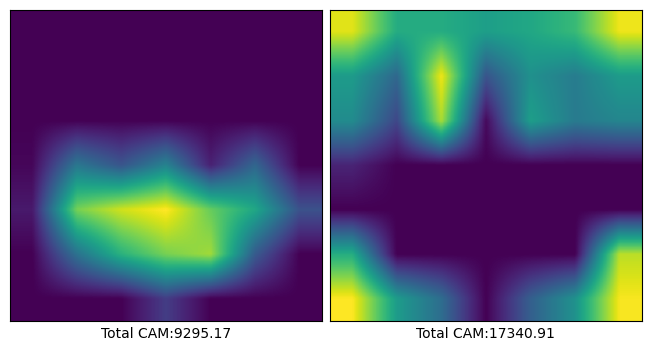

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
ax1.imshow(r['Acura_Acura_RDX_2b6f81bb13fd0f.jpg'])
ax1.set_xlabel(f'Total CAM:{r["Acura_Acura_RDX_2b6f81bb13fd0f.jpg"].sum():.2f}')
ax2.imshow(r['Acura_Acura_RDX_2f1773f3ed11bc.jpg'])
ax2.set_xlabel(f'Total CAM:{r["Acura_Acura_RDX_2f1773f3ed11bc.jpg"].sum():.2f}')

ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) 

ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

plt.savefig('test.pdf', bbox_inches='tight')

Using given results from file C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx


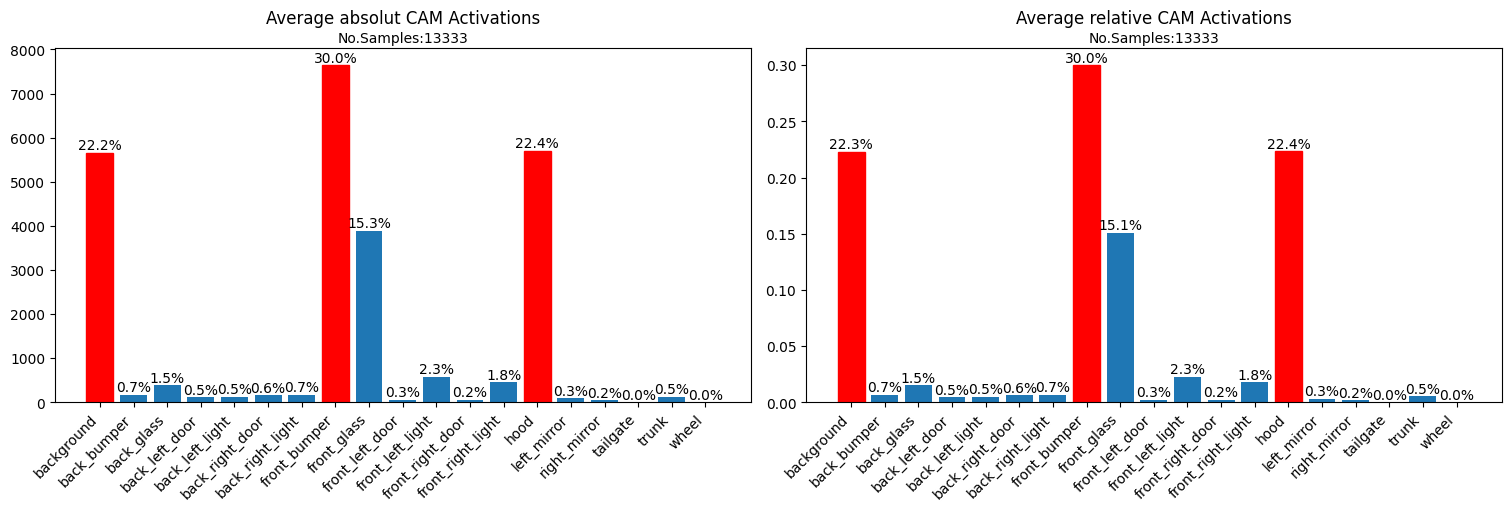

Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\firstStat.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\firstStat.pdf.xlsx
Using given results from file C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/statsProp/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_ShowPropArea_23_08_2022.xlsx


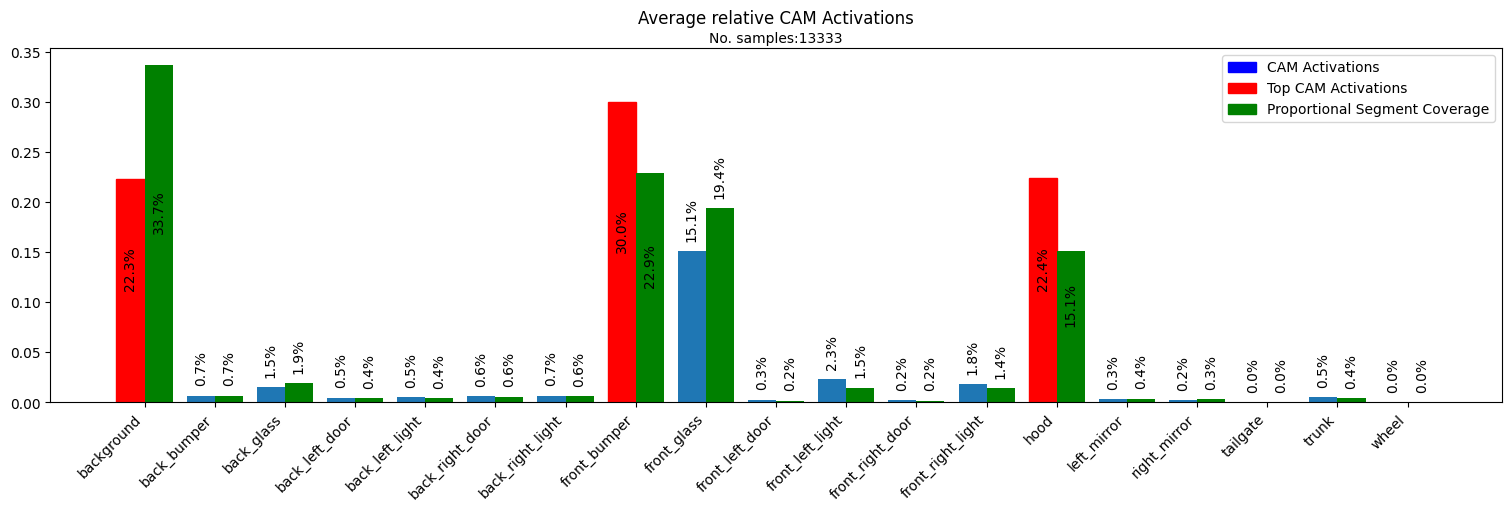

Output path is not a directory. Using base directory: ./results\statsProp.
Saving images to: ./results\statsProp\propStat.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\statsProp\prop_propStat.pdf.xlsx
Using given results from file C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/normalized/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx


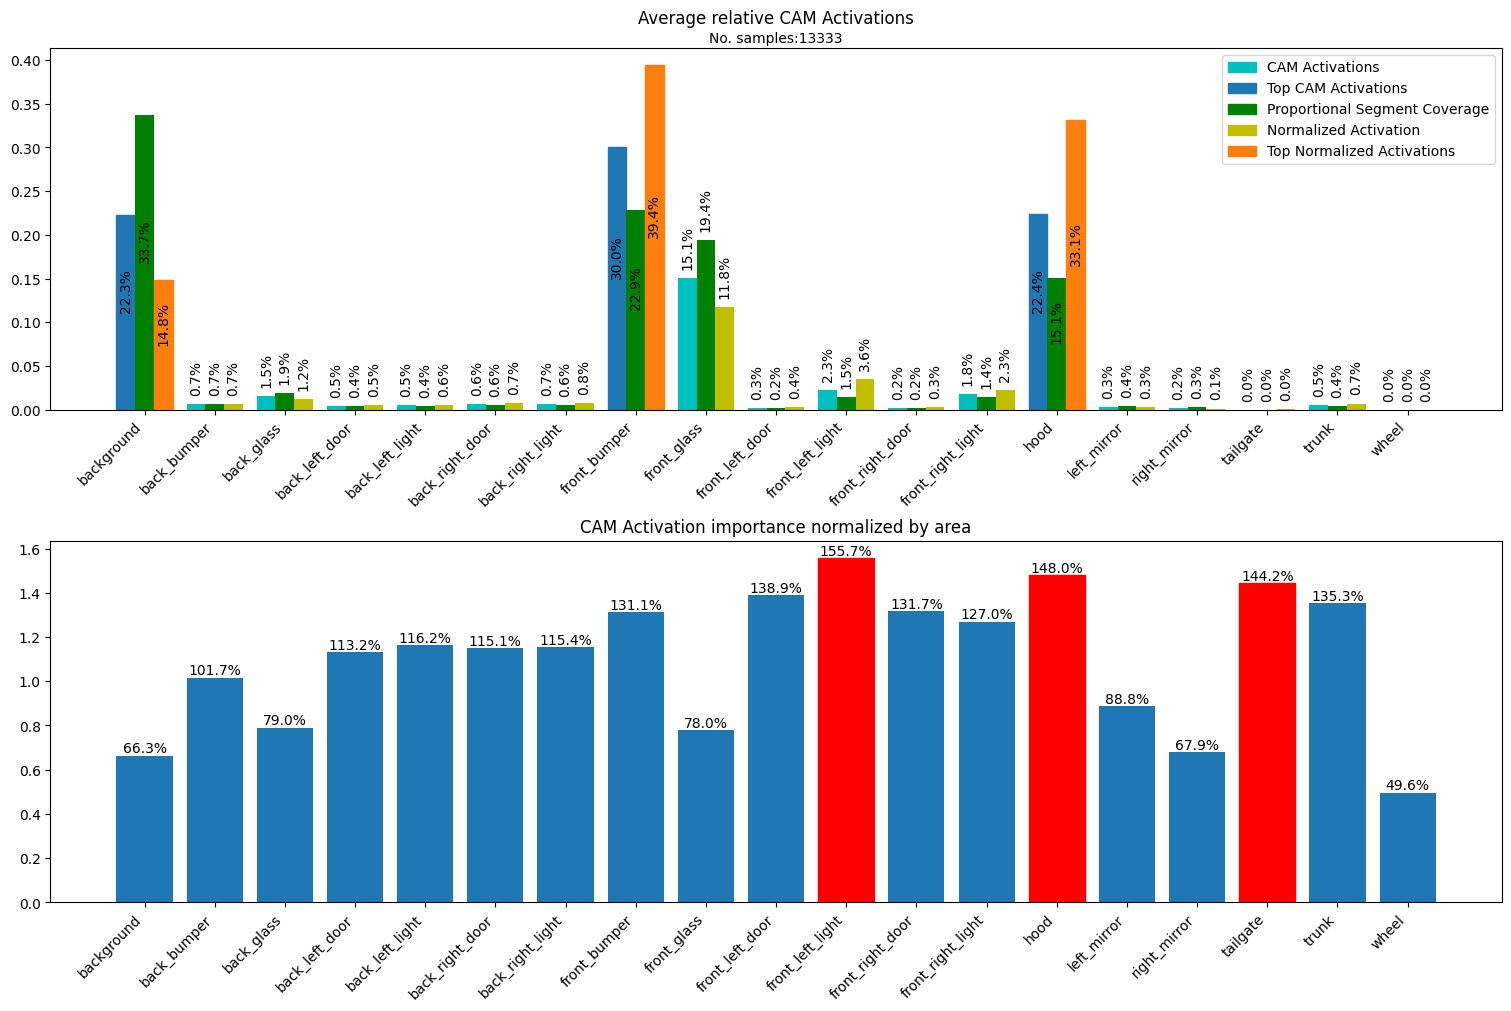

Output path is not a directory. Using base directory: ./results\normalized.
Saving images to: ./results\normalized\propStatNormal.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\normalized\normalized_propStatNormal.pdf.xlsx


In [63]:
generate_statistics.generate_statistic(results_file='C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx',
                                      filename='firstStat.pdf')
generate_statistics.generate_statistic_prop(results_file='C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/statsProp/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_ShowPropArea_23_08_2022.xlsx',
                                           filename='propStat.pdf', showPropPercent=True)
generate_statistics.generate_statistic_prop_normalized(results_file='C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/normalized/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx',
                                                      filename='propStatNormal.pdf', showPercent=True)

Using given Segmentation Data.
Loading data from file at ../preGenData/valAllSeg.npz
Using given CAM Data.
Loading data from file at ../preGenData/valAllCAMsGrad++.npz


C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\utils\prepareData.py:130: UserWarning: No pipeline is applied since segData is provided. If pipeline should be applied specify by pipelineCfg parameter.
  warnings.warn('No pipeline is applied since segData is provided. If pipeline should be applied specify '


load checkpoint from local path: ../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth
Accumulating Statistics for given imgNames.
Generate Statistics Data
Generate TotalCAM Stats


C:\Users\Linus\anaconda3\envs\mmseg\lib\site-packages\matplotlib\transforms.py:1896: ResourceWarning: unclosed file <_io.BufferedReader name='../preGenData/valAllSeg.npz'>
  super().__init__(**kwargs)
C:\Users\Linus\anaconda3\envs\mmseg\lib\site-packages\matplotlib\transforms.py:1896: ResourceWarning: unclosed file <_io.BufferedReader name='../preGenData/valAllCAMsGrad++.npz'>
  super().__init__(**kwargs)
C:\Users\Linus\anaconda3\envs\mmseg\lib\site-packages\matplotlib\transforms.py:1896: ResourceWarning: unclosed file <_io.BufferedReader name='../preGenData/valAllSeg.npz'>
  super().__init__(**kwargs)
C:\Users\Linus\anaconda3\envs\mmseg\lib\site-packages\matplotlib\transforms.py:1896: ResourceWarning: unclosed file <_io.BufferedReader name='../preGenData/valAllCAMsGrad++.npz'>
  super().__init__(**kwargs)


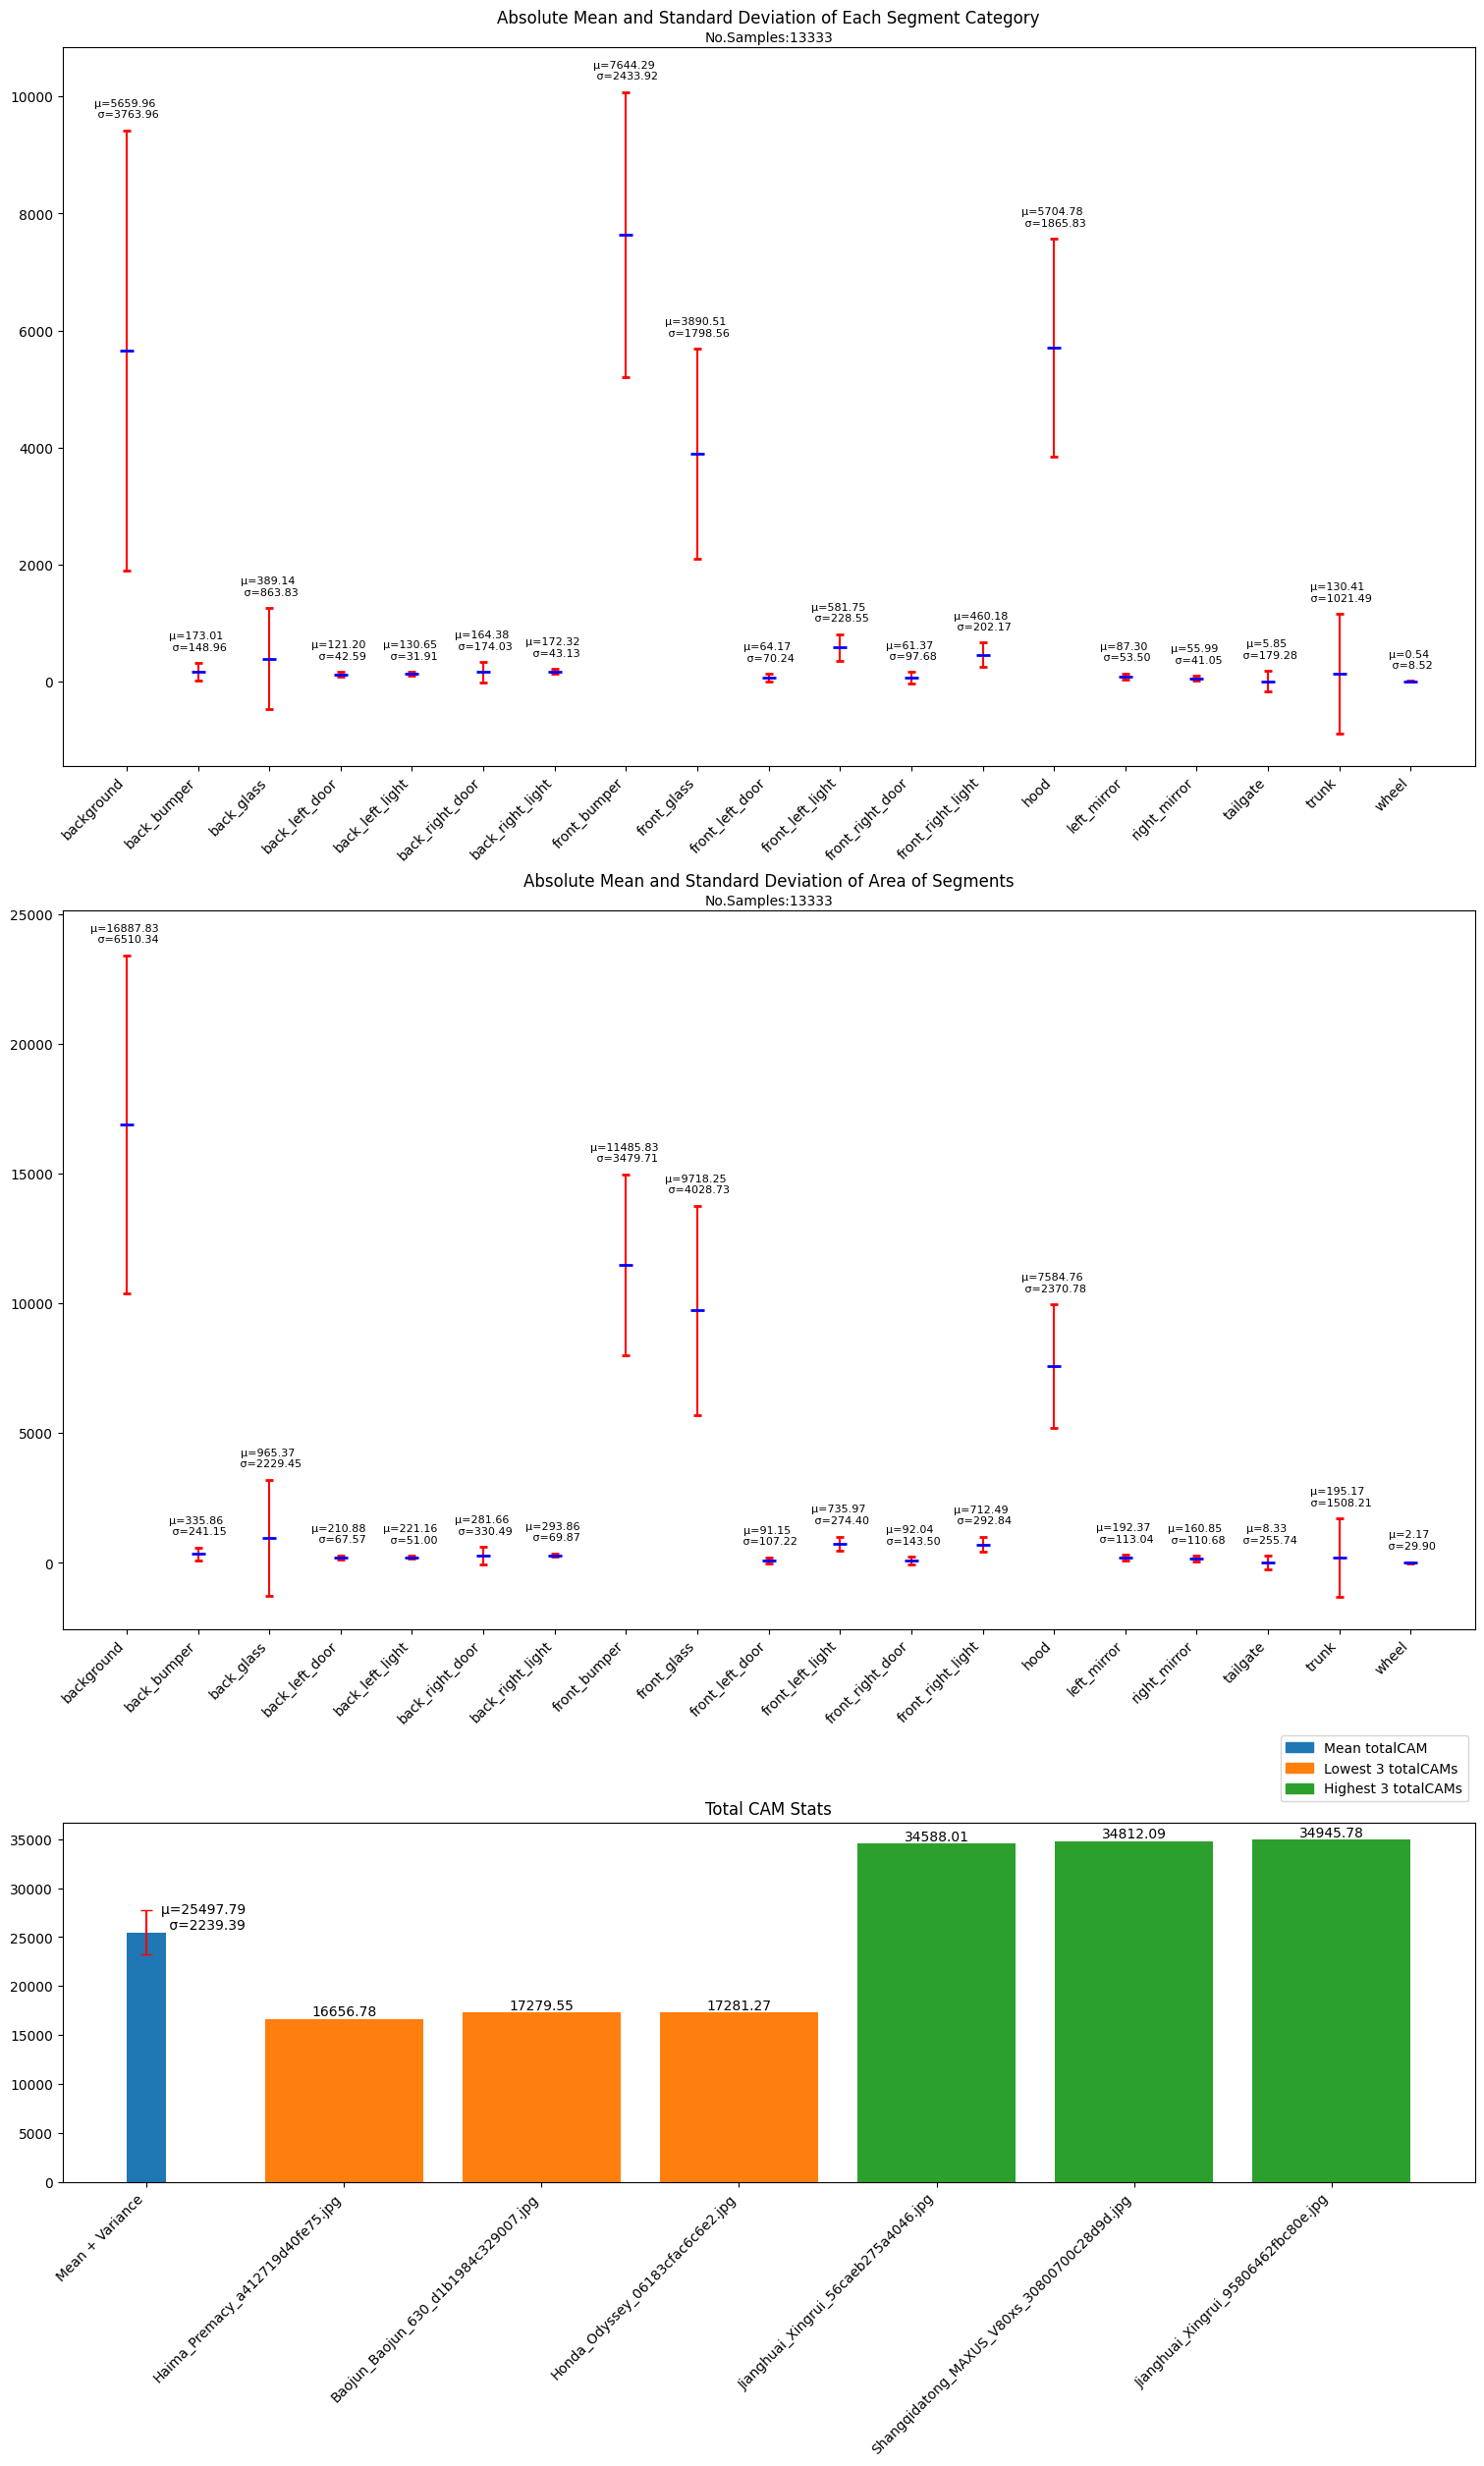

Output path is not a directory. Using base directory: ./results\meanStdTotal.
Saving images to: ./results\meanStdTotal\regenMeanStdStat.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\meanStdTotal\meanStdTotal_regenMeanStdStat.pdf.xlsx


In [61]:
generate_statistics.generate_statistics_mean_variance_total(filename='regenMeanStdStat.pdf', imgRoot=imgRootValOriginal,
                                                           annfile=annfileValOriginal, camConfig=configCAMResOG, 
                                                           camCheckpoint=checkpointCAMResOG, camData='../preGenData/valAllCAMsGrad++.npz',
                                                           segConfig=configSeg, segCheckpoint=checkpointSeg, segData='../preGenData/valAllSeg.npz',
                                                           saveAdditional=False)

Using given results from file C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/wronglyClassifications/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


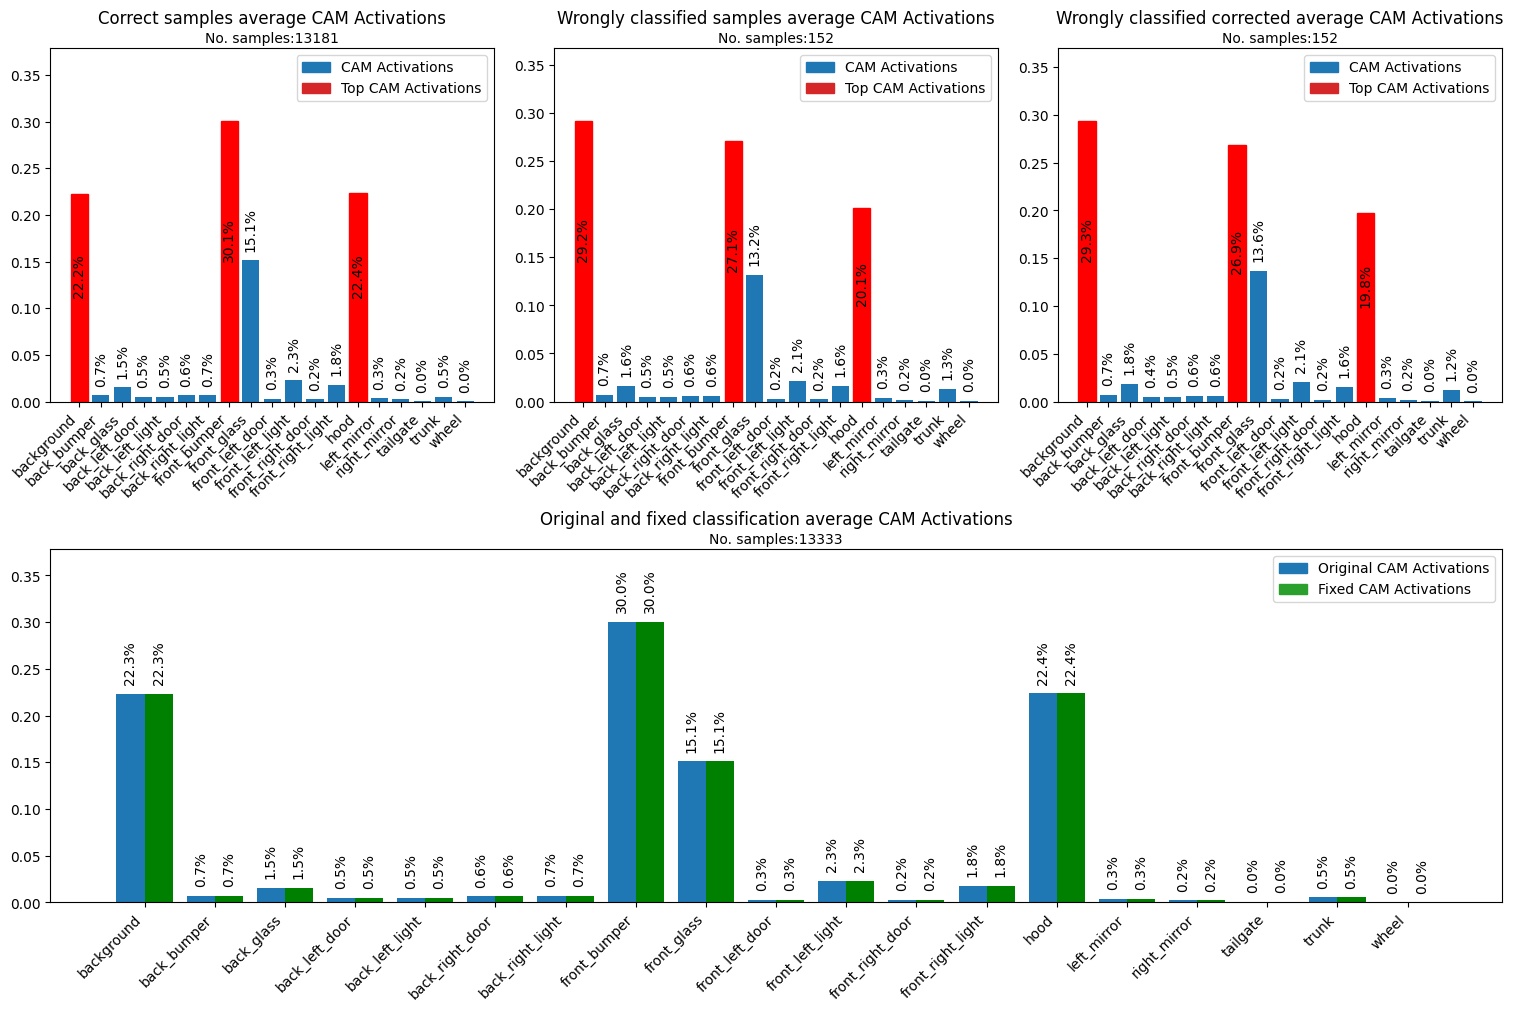

Output path is not a directory. Using base directory: ./results\wronglyClassifications.
Saving images to: ./results\wronglyClassifications\wronglyStat.pdf
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ./results\wronglyClassifications\wronglyClassified_wronglyStat.pdf.xlsx


In [65]:
generate_statistics.generate_statistics_missclassified(results_file='C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/wronglyClassifications/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx',
                                                      filename='wronglyStat.pdf')